<B><H2> MELBOURNE HOUSE PRICE ESTIMATOR </H2></B><H5>TENSORFLOW REGRESSION SEQUENTIAL DNN MODEL</H5>


In [79]:
import docker
import json
import numpy as np
import pandas as pd



#TENSORFLOW API
import tensorflow as tf
import tensorflow_data_validation as tfdv
# Feature Engineering
from tensorflow import feature_column as fc
from keras.models import Sequential
from keras import layers
from keras import utils
# TF Dataset for input pipeline
import tensorflow_datasets as tfds

# VISUALISATION API
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn is a Python data visualization library based on matplotlib.

# Import train_test_split function from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Used to calculate stats such as Z score, standard deviation etc.
from scipy import stats


<H5> READ THE DATA INTO PANDAS DATAFRAME.</H5> Remove any NULL values

In [50]:
# Import data from CSV into pandas DF
df= pd.read_csv('Melbourne_housing_FULL.csv')
# Check if there any NULL or NaN values
df.isnull().sum()
# Drop any NA values
df = df.dropna(how='any',axis=0)
# Check that there is no longer Null values
df.isnull().sum()
# Look at DF to get a feel of data
df.sample(5)


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
4819,Glenroy,1/25 Morell St,3,h,420000.0,PI,Raine,15/10/2016,13.0,3046.0,...,1.0,2.0,0.0,96.0,1960.0,Moreland City Council,-37.70250,144.95040,Northern Metropolitan,8870.0
7131,Newport,7 Durkin St,3,h,945000.0,S,Jas,28/05/2016,8.4,3015.0,...,2.0,1.0,487.0,190.0,2017.0,Hobsons Bay City Council,-37.84380,144.88060,Western Metropolitan,5498.0
7686,Pascoe Vale,27 Sefton St,3,h,975000.0,SP,Brad,15/10/2016,9.9,3044.0,...,1.0,3.0,686.0,151.0,1970.0,Moreland City Council,-37.72310,144.92520,Northern Metropolitan,7485.0
34512,Mitcham,15 Nara Rd,3,h,1070000.0,VB,Noel,24/02/2018,17.2,3132.0,...,2.0,1.0,654.0,164.0,1974.0,Whitehorse City Council,-37.80953,145.20869,Eastern Metropolitan,6871.0
24707,South Morang,15 Trinity Wy,3,h,520000.0,S,The,14/10/2017,20.5,3752.0,...,2.0,2.0,552.0,147.0,2010.0,Whittlesea City Council,-37.63693,145.06482,Northern Metropolitan,7969.0


In [ ]:
df.info()

<H4>Define Numeric, Categorical & features that need to be dropped.</H4>
Drop unwanted features

In [52]:
# Above there is a combination of categorical & numerical features with 'Price' being the label. We will need to classify the 
# features into the following:

num_feat = ['Rooms','Distance','Bathroom','Car','Landsize','BuildingArea','YearBuilt','Propertycount','Lattitude','Longtitude']
cat_feat = ['Type','Suburb','Method','SellerG']
drop_feat = ['Address','Postcode','CouncilArea','Regionname','Bedroom2','Date']
# Drop features that are not required
if set(drop_feat).issubset(df.columns):
  df = df.drop(drop_feat, axis = 1)

#df = df.astype('float64')
df.head()

,Suburb,Rooms,Type,Price,Method,SellerG,Distance,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
2,Abbotsford,2,h,1035000.0,S,Biggin,2.5,1.0,0.0,156.0,79.0,1900.0,-37.8079,144.9934,4019.0
4,Abbotsford,3,h,1465000.0,SP,Biggin,2.5,2.0,0.0,134.0,150.0,1900.0,-37.8093,144.9944,4019.0
6,Abbotsford,4,h,1600000.0,VB,Nelson,2.5,1.0,2.0,120.0,142.0,2014.0,-37.8072,144.9941,4019.0
11,Abbotsford,3,h,1876000.0,S,Nelson,2.5,2.0,0.0,245.0,210.0,1910.0,-37.8024,144.9993,4019.0
14,Abbotsford,2,h,1636000.0,S,Nelson,2.5,1.0,2.0,256.0,107.0,1890.0,-37.8060,144.9954,4019.0


<H4> EXPLORATORY DATA ANALYSIS (EDA) </H4>

Explore Relationships between Numerical Features & Price (label)

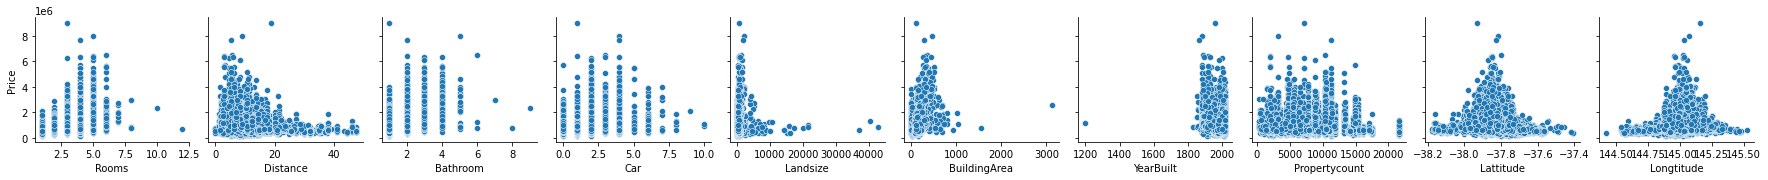

In [53]:
sns.pairplot(data = df,y_vars=['Price'],x_vars=num_feat)

Using Pandas statistics to look for Outliers

In [54]:
df.describe()

,Rooms,Price,Distance,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,8887.000000,8.887000e+03,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000
mean,3.098909,1.092902e+06,11.199887,1.646450,1.692247,523.480365,149.309477,1965.753348,-37.804501,144.991393,7475.940137
std,0.963786,6.793819e+05,6.813402,0.721611,0.975464,1061.324228,87.925580,37.040876,0.090549,0.118919,4375.024364
min,1.000000,1.310000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,1196.000000,-38.174360,144.423790,249.000000
25%,2.000000,6.410000e+05,6.400000,1.000000,1.000000,212.000000,100.000000,1945.000000,-37.858560,144.920000,4382.500000
50%,3.000000,9.000000e+05,10.200000,2.000000,2.000000,478.000000,132.000000,1970.000000,-37.798700,144.998500,6567.000000
75%,4.000000,1.345000e+06,13.900000,2.000000,2.000000,652.000000,180.000000,2000.000000,-37.748945,145.064560,10331.000000
max,12.000000,9.000000e+06,47.400000,9.000000,10.000000,42800.000000,3112.000000,2019.000000,-37.407200,145.526350,21650.000000


Filter out Outliers using either Z Score Method (normal discribution) or IQR method.

In [55]:
method = 'Zscore'
# Interquartile range (IQR) method should be used for NON normal distribution

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

if method == 'Zscore':
  df = df[(np.abs(stats.zscore(df[num_feat])) < 3).all(axis=1)]
else:
  remove_outlier(df, num_feat)


Confirm that Outliers have been removed

In [56]:
df.describe()

,Rooms,Price,Distance,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,8037.000000,8.037000e+03,8037.000000,8037.000000,8037.000000,8037.000000,8037.000000,8037.000000,8037.000000,8037.000000,8037.000000
mean,3.043424,1.086129e+06,10.417519,1.602464,1.610178,445.300236,142.295623,1964.713077,-37.804632,144.992914,7103.671644
std,0.911041,6.287808e+05,5.488882,0.638182,0.838776,344.364158,65.804524,36.549564,0.080220,0.108025,3803.346628
min,1.000000,1.310000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,1856.000000,-38.072300,144.637610,389.000000
25%,2.000000,6.520000e+05,6.300000,1.000000,1.000000,198.000000,99.000000,1940.000000,-37.857760,144.921200,4258.000000
50%,3.000000,9.100000e+05,9.700000,2.000000,2.000000,444.000000,130.000000,1970.000000,-37.800900,144.996700,6543.000000
75%,4.000000,1.350000e+06,13.800000,2.000000,2.000000,638.000000,176.000000,2000.000000,-37.754400,145.062700,9264.000000
max,5.000000,9.000000e+06,31.200000,3.000000,4.000000,3701.000000,413.000000,2019.000000,-37.566920,145.337380,17496.000000


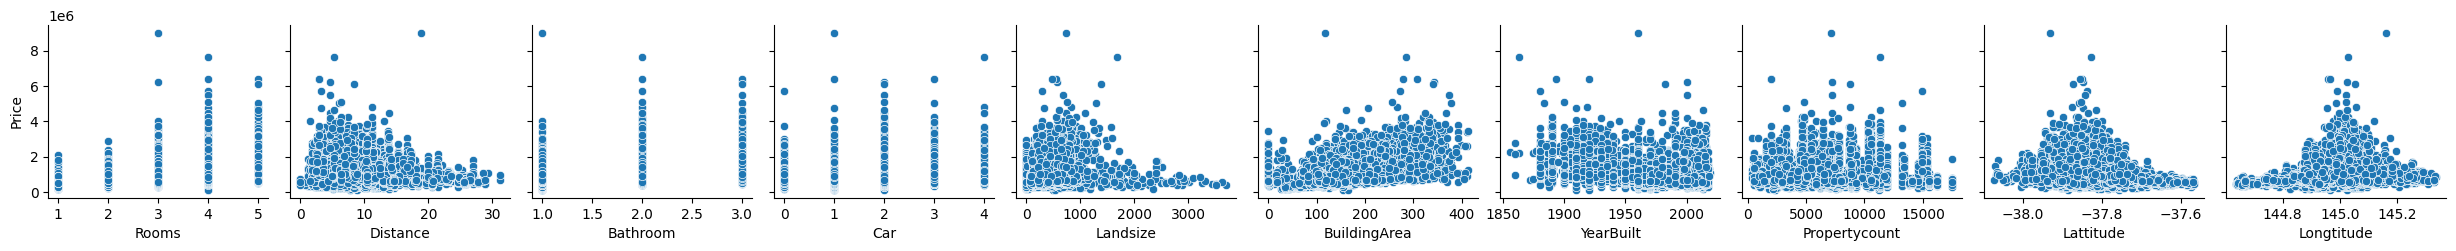

In [91]:
sns.pairplot(data = df,y_vars=['Price'],x_vars=num_feat)

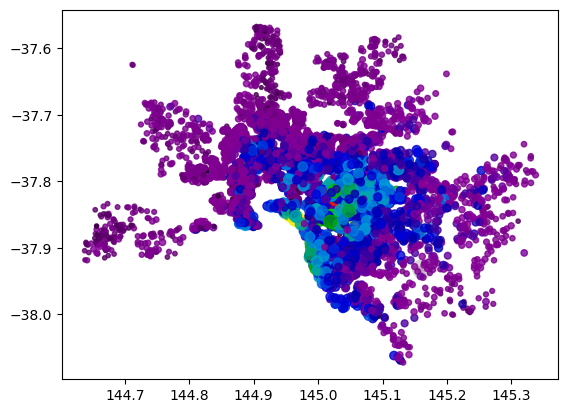

In [146]:
plt.scatter(x = df['Longtitude'], y = df['Lattitude'],c =df['Price'],alpha=0.8,s=df['Price']/50000,cmap='nipy_spectral' )

Data Splitting into TRAIN,VALIDATION & TEST using Scikit Learn function

In [93]:
# Let's split the dataset into train, validation, and test sets as Pandas DF format
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

5143 train examples
1286 validation examples
1608 test examples


Defining function to convert Pandas Data Frame (DF) to Tensorflow Data Set (DS)

In [122]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('Price')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

Converting the training & Valuation data frames to data sets

In [123]:
batch_size = 32
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

Inspect Train data set

In [96]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of distances:', feature_batch['Distance'])
  print('A batch of targets:', label_batch )

Every feature: ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG', 'Distance', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
A batch of distances: tf.Tensor(
[ 6.5 23.   9.9 23.  27.  10.5 13.   3.   6.5  2.6  8.  16.1  9.2  7.9
  7.8  3.6  1.6 11.2  2.4 15.2 11.   7.7 20.   7.8  7.8 17.4  7.8  1.6
  9.2 12.9  9.9  7.8], shape=(32,), dtype=float64)
A batch of targets: tf.Tensor(
[ 600000.  865000. 1196000. 1175000. 1031000. 1826000.  620250. 2010000.
  365000.  950000. 1131000.  708000.  700000. 2400000. 2700000. 1460000.
 1260000. 1755000. 1750000. 2700000. 1665000. 2175000.  800000. 1690000.
  680000.  495000.  729000. 1950000.  930000.  790000.  650000. 2030000.], shape=(32,), dtype=float64)


Defining a normalization/scaling function to be used for numerical features

In [97]:
# Define Scalar function to normalise numerical features for training set
def get_scal(feature):
    def minmax(x):
        mini = train_ds[feature].min()
        maxi = train_ds[feature].max()
        return (x - mini)/(maxi-mini)
        return(minmax)


Creating a new list of features made up of scaled numerical feature colums

In [98]:
# Define new empty feature columns & fill it with scaled numerical features
feature_columns = []
for header in num_feat:
    scal_input_fn = get_scal(header)
    feature_columns.append(fc.numeric_column(header,normalizer_fn=scal_input_fn))



print('Total number of feature coLumns: ', len(feature_columns))


Total number of feature coLumns:  10


Performing One Hot Encoding for CATEGORICAL features & adding them to Feature Columns

In [99]:
for feature_name in cat_feat:
    vocabulary = df[feature_name].unique()
    categorical_c = fc.categorical_column_with_vocabulary_list(feature_name, vocabulary)
    one_hot = fc.indicator_column(categorical_c)
    feature_columns.append(one_hot)


print('Total number of feature coLumns after adding categorical: ', len(feature_columns))

Total number of feature coLumns after adding categorical:  14


In [100]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = tf.keras.layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())


distance_count = fc.numeric_column('Distance')
demo(distance_count)

[[11.2]
 [25.9]
 [11.7]
 [ 6.3]
 [16.1]
 [ 7.3]
 [12.9]
 [14.5]
 [17.9]
 [16.1]
 [14.7]
 [12.3]
 [10.8]
 [ 6.8]
 [ 7.8]
 [ 7.8]
 [ 9.2]
 [ 4.6]
 [ 7. ]
 [10.8]
 [17.4]
 [10.5]
 [14.8]
 [14. ]
 [23.5]
 [13.9]
 [10.7]
 [12.4]
 [12.1]
 [ 1.9]
 [ 9.7]
 [ 5.5]]


Defining a Tensorflow Sequential Regression DNN model.

In [101]:
#train_ds = train_ds.unbatch()
# Model create
# `tf.keras.layers.DenseFeatures()` is a layer that produces a dense Tensor based on given feature_columns.
feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')
# `tf.keras.Sequential()` groups a linear stack of layers into a tf.keras.Model.
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='linear',  name='Price')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds,validation_data=val_ds,epochs=10)



Epoch 1/10
161/161 [==============================] - 7s 17ms/step - loss: 1168580804608.0000 - mse: 1168580804608.0000 - val_loss: 548383522816.0000 - val_mse: 548383522816.0000
Epoch 2/10
161/161 [==============================] - 2s 12ms/step - loss: 498693406720.0000 - mse: 498693406720.0000 - val_loss: 484647895040.0000 - val_mse: 484647895040.0000
Epoch 3/10
161/161 [==============================] - 2s 12ms/step - loss: 440768299008.0000 - mse: 440768299008.0000 - val_loss: 420437360640.0000 - val_mse: 420437360640.0000
Epoch 4/10
161/161 [==============================] - 2s 11ms/step - loss: 393070346240.0000 - mse: 393070346240.0000 - val_loss: 376735170560.0000 - val_mse: 376735170560.0000
Epoch 5/10
161/161 [==============================] - 2s 11ms/step - loss: 368859414528.0000 - mse: 368859414528.0000 - val_loss: 360119959552.0000 - val_mse: 360119959552.0000
Epoch 6/10
161/161 [==============================] - 2s 11ms/step - loss: 359631028224.0000 - mse: 359631028224.

In [102]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [103]:
loss, mse = model.evaluate(train_ds)
print("Mean Squared Error", mse)

161/161 [==============================] - 1s 8ms/step - loss: 339541393408.0000 - mse: 339541393408.0000
Mean Squared Error 339541393408.0


In [104]:
# Use matplotlib to draw the model's loss curves for training and validation
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');  

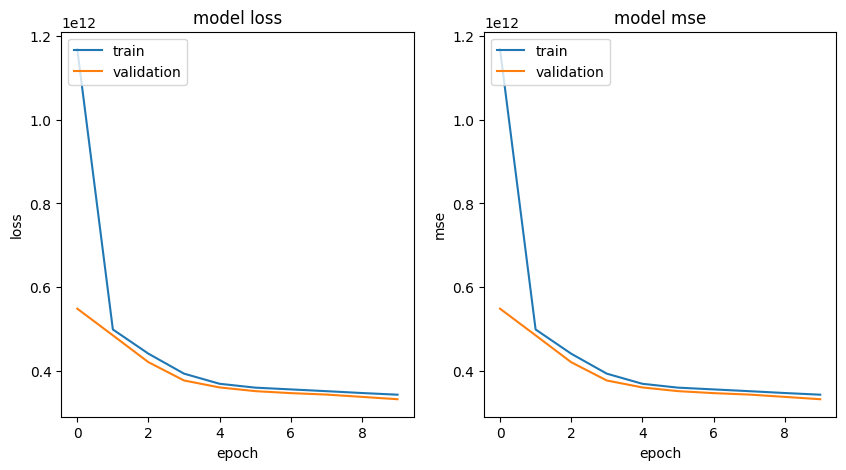

In [105]:
plot_curves(history, ['loss', 'mse'])

Prediction of Price for the

In [121]:
test.head(10)

,Suburb,Rooms,Type,Price,Method,SellerG,Distance,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
19255,Albanvale,3,h,555000.0,SP,Sweeney,14.0,1.0,3.0,566.0,126.0,1980.0,-37.74306,144.76679,1899.0
11825,West Footscray,3,h,805000.0,S,Jas,8.2,1.0,3.0,372.0,96.0,1920.0,-37.79600,144.87280,5058.0
6443,Malvern East,3,h,1870000.0,S,Jellis,11.2,2.0,1.0,400.0,152.0,1930.0,-37.87180,145.04040,8801.0
13790,Surrey Hills,3,h,1525000.0,S,Fletchers,11.2,2.0,2.0,347.0,195.0,2013.0,-37.83230,145.10500,5457.0
8221,Preston,4,h,1400000.0,VB,Jellis,8.8,2.0,2.0,559.0,217.0,1925.0,-37.73470,144.99660,14577.0
19553,Melbourne,2,u,565000.0,S,MICM,0.0,1.0,0.0,89.0,85.0,2003.0,-37.80802,144.96168,17496.0
12062,Keilor Park,2,t,380000.0,S,Nelson,14.5,1.0,1.0,161.0,100.0,2010.0,-37.72510,144.86210,1119.0
7579,Oakleigh South,4,h,937500.0,SP,Greg,14.7,2.0,2.0,539.0,226.0,1993.0,-37.94130,145.09570,3692.0
7399,Northcote,2,h,1095000.0,S,Ray,5.5,1.0,2.0,306.0,86.0,1910.0,-37.76440,145.00400,11364.0
34074,Camberwell,2,h,1550000.0,VB,Marshall,7.7,2.0,2.0,606.0,118.0,1930.0,-37.84764,145.09273,8920.0


In [ ]:
for line in test_ds.take(1):
  print(line)

In [106]:
predictions = model.predict(test_ds)


51/51 [==============================] - 1s 10ms/step


In [107]:
for i in range(50):
    diff = (predictions[i][0] - test['Price'].iloc[i])/1000
    print('PREDICTION: ${0}'.format(predictions[i][0]) + '   ACTUAL: '+format(test['Price'].iloc[i]) + f' DIFFERENCE: ${diff}')
  

PREDICTION: $1111481.875   ACTUAL: 555000.0 DIFFERENCE: $556.481875
PREDICTION: $996469.875   ACTUAL: 805000.0 DIFFERENCE: $191.469875
PREDICTION: $1077956.875   ACTUAL: 1870000.0 DIFFERENCE: $-792.043125
PREDICTION: $1130061.25   ACTUAL: 1525000.0 DIFFERENCE: $-394.93875
PREDICTION: $1212704.25   ACTUAL: 1400000.0 DIFFERENCE: $-187.29575
PREDICTION: $929383.875   ACTUAL: 565000.0 DIFFERENCE: $364.383875
PREDICTION: $941479.5625   ACTUAL: 380000.0 DIFFERENCE: $561.4795625
PREDICTION: $1221816.625   ACTUAL: 937500.0 DIFFERENCE: $284.316625
PREDICTION: $965500.1875   ACTUAL: 1095000.0 DIFFERENCE: $-129.4998125
PREDICTION: $1118476.875   ACTUAL: 1550000.0 DIFFERENCE: $-431.523125
PREDICTION: $1144450.0   ACTUAL: 835000.0 DIFFERENCE: $309.45
PREDICTION: $1277511.5   ACTUAL: 732000.0 DIFFERENCE: $545.5115
PREDICTION: $1022909.3125   ACTUAL: 478000.0 DIFFERENCE: $544.9093125
PREDICTION: $1334884.25   ACTUAL: 2525000.0 DIFFERENCE: $-1190.11575
PREDICTION: $1059362.5   ACTUAL: 1222500.0 DIFFER

Exploratory Data Analysis (EDA)

In [ ]:
plt.scatter(train['Price'].iloc[0:1000],predictions[0:1000])

SAVE MODEL

In [ ]:
model.save("saved_models/V1/")

In [42]:
#docker run -it -v /home/khaled/AUTOMATION-EXCEL\:/tf_serving -p 8601:8601 --entrypoint /bin/bash tensorflow/serving
#tensorflow_model_server --rest_api_port=8601 --model_name=melb_price --model_base_path=/tf_serving/saved_models/

client = docker.from_env()
container = client.containers.run(image = "tensorflow/serving", ports = {8601:8601},volumes = ['/home/khaled/AUTOMATION-EXCEL/:/tf_serving'], detach=True)
container.exec_run('/bin/bash')
print(container.exec_run('ls'))
container.exec_run('tensorflow_model_server --rest_api_port=8601 --model_name=melb_price --model_base_path=/tf_serving/saved_models/',detach = True)

ExecResult(exit_code=0, output=b'bin\nboot\ndev\netc\nhome\nlib\nlib64\nmedia\nmnt\nmodels\nopt\nproc\nroot\nrun\nsbin\nsrv\nsys\ntf_serving\ntmp\nusr\nvar\n')


ExecResult(exit_code=None, output='')

In [108]:
inputExample = train.to_json()

In [127]:
X = json.dumps(test_ds.take(1))

#type(X)

#print(tf.keras.layers.serialize(model))
print(train_ds.take(1))

TypeError: Object of type TakeDataset is not JSON serializable

In [120]:
%%bash
curl -d '{"instances": X' -X POST http://localhost:8601/v1/models/melb_price:predict

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    80  100    65  100    15   4062    937 --:--:-- --:--:-- --:--:--  5000


{
    "error": "JSON Parse error: Invalid value. at offset: 14"
}